In [31]:
%load_ext autoreload
%autoreload 2

from utils import *
import numpy as np
import pandas as pd
import sys
sys.path.append("..")

from torch.utils import data

import glob
import random
import os
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns


from io import StringIO

from bokeh.io import push_notebook, show, output_notebook,reset_output
from bokeh.plotting import figure
import networkx as nx
from bokeh.plotting import figure, from_networkx, curdoc
from bokeh.models import Rect, HoverTool,  TextInput, GraphRenderer, Circle
from bokeh.io import output_file
from bokeh.plotting import figure, output_file, save
from bokeh.models import (BoxZoomTool, Circle, Line, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.models import LinearColorMapper, BasicTicker, ColorBar,CustomJSHover,CustomJS
from bokeh.models import Ellipse, GraphRenderer, StaticLayoutProvider

import grandalf


output_notebook()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
QDIR = os.path.join("/Users/pari/LatencyCollector/queries")

JOB_QNAMES = get_qnames(os.path.join(QDIR, "job"))
CEB_QNAMES = get_qnames(os.path.join(QDIR, "ceb-small"))
ERG_QNAMES = get_qnames(os.path.join(QDIR, "ergast-small"))
STATS_QNAMES = get_qnames(os.path.join(QDIR, "stats"))
JOBLT_QNAMES = get_qnames(os.path.join(QDIR, "joblight_train"))
STACK_QNAMES = get_qnames(os.path.join(QDIR, "stack-small"))
TPCH_QNAMES = get_qnames(os.path.join(QDIR, "tpch"))
ACC_QNAMES = get_qnames(os.path.join(QDIR, "accidents"))

LT_FN = "lt_instances.txt"

#EXP_NAMES = ["exp-debug-stack"]

EXP_NAMES = ["exp1_single", "exp2_single", "exp3_single"]
#EXP_NAMES = ["exp3_single"]

#EXP_NAMES = ["exp8_single_stack"]
#EXP_NAMES = ["exp5_single_stats"]
#EXP_NAMES = ["exp6_single_joblight"]
#EXP_NAMES = ["exp7_single_ceb2"]
#EXP_NAMES = ["exp12_single_scaled_zdbs3"]
#EXP_NAMES = ["exp4_single_ergast"]
#EXP_NAMES = ["exp9_single_tpch"]

#RESULTDIR = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "new", EXP_NAME)

LT_TYPES = '''a1_large_mag_4g=lt-0d15fb8f5bbe9a27d
a1_large_gp3_4g=lt-04840b55d3f795395
r7g_large_gp2_16g=lt-0212ec953ba35b176
t3_large_gp2_8g=lt-05d2d354bc3dd9133
c5a_large_mag_4g=lt-03218e9e27718bbbe
m6a_large_mag_8g=lt-0f6f46002652f9a4c
t3a_medium_gp3_4g=lt-0af65294350b1a8c1
t3a_large_gp3_8g=lt-084bfbae110d52d4e
r6a_large_mag_16g=lt-0e608666ff3adff07
t4g_large_mag_8g=lt-04e0b4826c63bfadb
c7g_large_mag_4g=lt-0af47c6caa3b53b8b
r7g_medium_gp2_16g=lt-01d0081183a7d79f2
t3_xlarge_gp2_16g=lt-0b413bcc22b3ac8fb
'''

lt_types = pd.read_csv(StringIO(LT_TYPES), sep="=", header=None, 
                       names=["lt_type", "lt"])

# print(os.path.exists(RESULTDIR))

dfs = []
for exp in EXP_NAMES:
    resultdir = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "new", exp)
    #resultdir = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "duckdb", exp)
    assert os.path.exists(resultdir)
    ltdf = pd.read_csv(os.path.join(resultdir, LT_FN), header=None, 
                   names=["instance", "lt"])
    ltdf = ltdf.merge(lt_types, on="lt")
    
    rtfns = glob.iglob(resultdir + "/*/results/Runtime*.csv")

    for rtfn in rtfns:
        instance_name = os.path.basename(os.path.dirname(os.path.dirname(rtfn)))
        rt = pd.read_csv(rtfn)
        rt["instance"] = instance_name
        rt = rt.merge(ltdf, on="instance")
        if len(rt) == 0:
            print(instance_name)
            continue
        mintime = min(rt["start_time"].values)
        rt["relative_start_time"] = rt.apply(lambda x: x["start_time"]-mintime , axis=1)

        dfs.append(rt)
    
df = pd.concat(dfs)
df = df[df["lt_type"] == "t3_large_gp2_8g"]
print("Instances: ", set(df["lt_type"]))

i-062356c12e9a13a20
Instances:  {'t3_large_gp2_8g'}


In [38]:
# QDIR = os.path.join("/Users/pari/LatencyCollector/queries")
# JOB_QNAMES = get_qnames(os.path.join(QDIR, "job"))
# CEB_QNAMES = get_qnames(os.path.join(QDIR, "ceb-small"))

# MULTIPLE=False
# EXP_NAME = "CEB-t2medium-gp2"
# #EXP_NAME = "CEB-t2small-gp3"
# #EXP_NAME = "CEB-t2medium-gp3"
# #EXP_NAME = "m5ad-gp2"
# #EXP_NAME = "CEB-c7large-gp2"


# #MULTIPLE=True
# ## w/ 16 processes
# #EXP_NAME = "t7xlarge-gp3-c"

# ## w/ 9 processes
# #EXP_NAME = "t7xlarge-gp3-f-stressng"

# if MULTIPLE:
#     RESULTDIR = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "multiple", EXP_NAME)
# else:
#     RESULTDIR = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", EXP_NAME)
    

# #RESULTDIR = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults")
# print(RESULTDIR)
# #CEB-t2medium-gp2

In [39]:
# print(os.path.exists(RESULTDIR))

# rtfns = glob.iglob(RESULTDIR + "/*/results/Runtime*.csv")
# dfs = []

# for rtfn in rtfns:
#     dfs.append(pd.read_csv(rtfn))
    
# df = pd.concat(dfs)

In [40]:
print(df["runtime"].sum())
print(df["runtime"].describe())

28532.724780082703
count    789.000000
mean      36.163149
std      105.345992
min        0.004815
25%        1.008178
50%        4.427474
75%       18.554183
max      909.000000
Name: runtime, dtype: float64


In [41]:
qworkloads = {}
for qname in JOB_QNAMES:
    qworkloads[qname] = "JOB"
for qname in CEB_QNAMES:
    qworkloads[qname] = "CEB"
    
df["workload"] = df.apply(lambda x: qworkloads[x["qname"]] , axis=1)
df.groupby(["workload"])["runtime"].describe(percentiles=[0.75, 0.9,0.99])

,count,mean,std,min,50%,75%,90%,99%,max
workload,,,,,,,,,
CEB,450.0,56.661381,133.393153,0.057155,7.989162,34.787584,155.798528,771.033398,909.000000
JOB,339.0,8.953107,30.556571,0.004815,1.652560,7.104749,18.115178,166.567768,340.786287


In [42]:
#df = df[df["runtime"] <= 900]

In [43]:
df.groupby("qname")["runtime"].describe(percentiles=[0.9]).sort_values(by="std", ascending=False).head(10).round(2)

,count,mean,std,min,50%,90%,max
qname,,,,,,,
00e9ce53d0b204dca29fc66397b95ee3ed779b2f.sql,3.0,339.48,493.22,52.53,56.92,738.58,909.00
7a121.sql,3.0,313.87,482.43,34.55,36.12,703.97,870.93
61a3414d00e8c4aac4ea1363179363942d80a208.sql,3.0,329.10,478.63,52.34,53.17,716.05,881.77
7a131.sql,3.0,363.80,472.16,90.92,91.47,745.49,909.00
7a160.sql,3.0,369.59,467.15,98.77,100.99,747.40,909.00
6a447.sql,3.0,250.58,360.68,40.46,44.22,542.49,667.06
6a26.sql,3.0,213.41,313.95,31.79,32.52,467.24,575.92
728f1ee9b87457c8b28490639330db5b8f5b1e1c.sql,3.0,211.60,303.95,34.87,37.36,457.52,562.56
2a67.sql,3.0,212.86,302.44,37.85,38.64,457.40,562.09


In [44]:
df["runtime"].values[0]

3.47927474975586

In [45]:
# total_times = extract_values(plan[0][0], 'Actual Total Time')
# total_times

In [46]:
import copy
def draw_plan(G):
    tmp = nx.Graph()
    for edge in G.edges():
        tmp.add_edge(edge[0], edge[1])
    pos = nx.nx_pydot.graphviz_layout(tmp, prog="dot")
    #pos = nx.nx_agraph.pygraphviz_layout(G, prog="dot")
    #print(pos)
    G = G.reverse()
    nx.draw(G, pos=pos)

In [47]:
tmp = df[df["qname"] == "8a.sql"]
print(tmp["runtime"])

reset_output()
output_notebook()

for exp in tmp["exp_analyze"].values:
    try:
        plan = eval(str(exp))
        #print(plan)
    except Exception as e:
        print(e)
        continue
        
    G = explain_to_nx(plan[0][0][0])
    #print(len(G.nodes()))
    aliases = extract_values(plan[0][0][0], "Alias")
    print(aliases)
    #draw_plan(G)
    bokeh_plot(G)
    #break

105     12.284534
368     12.147774
631    278.026648
Name: runtime, dtype: float64


Loading BokehJS ...

['mc', 'cn', 't', 'ci', 'rt', 'an1', 'n1']


ValueError: failed to validate StaticLayoutProvider(id='p1393', ...).graph_layout: expected an element of Dict(Int, Seq(Any)), got {'Aggregate449543': (647.54, 594.0), 'Nested Loop515623': (647.54, 522.0), 'Nested Loop787699': (559.54, 450.0), 'Index Scan-20070': (735.54, 450.0), 'Hash Join842176': (476.54, 378.0), 'Index Scan484016': (643.54, 378.0), 'Nested Loop-13861': (399.54, 306.0), 'Hash630650': (558.54, 306.0), 'Nested Loop794672': (222.54, 234.0), 'Index Scan108493': (399.54, 234.0), 'Hash Join-80978': (140.54, 162.0), 'Index Scan-69252': (304.54, 162.0), 'Seq Scan459813': (69.544, 90.0), 'Hash559586': (212.54, 90.0), 'Seq Scan870104': (212.54, 18.0), 'Seq Scan810805': (563.54, 234.0)}

In [ ]:
max(df["start_time"]) - min(df["start_time"])

In [48]:
mintime = min(df["start_time"])
df["relative_start_time"] = df.apply(lambda x: x["start_time"]-mintime , axis=1)

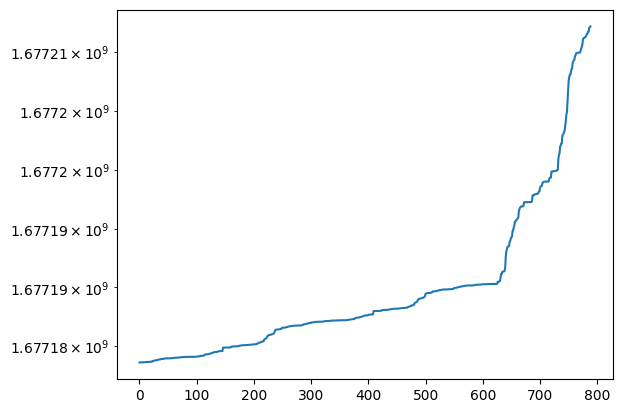

In [49]:
sns.lineplot(x=range(len(df["start_time"])), y=df["start_time"].values)
plt.yscale("log")

In [50]:
print(len(set(df["qname"])))

263


In [51]:
tmp = df[df["qname"] == "8a.sql"]
tmp[["relative_start_time", "qname", "runtime"]]

,relative_start_time,qname,runtime
105,534.276501,8a.sql,12.284534
368,3646.586628,8a.sql,12.147774
631,7256.940049,8a.sql,278.026648


In [52]:
# tmp1 = df[df["relative_start_time"] < 5800]
# tmp2 = df[df["relative_start_time"] >= 5800]
# tmp2 = tmp2[tmp2["relative_start_time"] < 8000]

<AxesSubplot: >

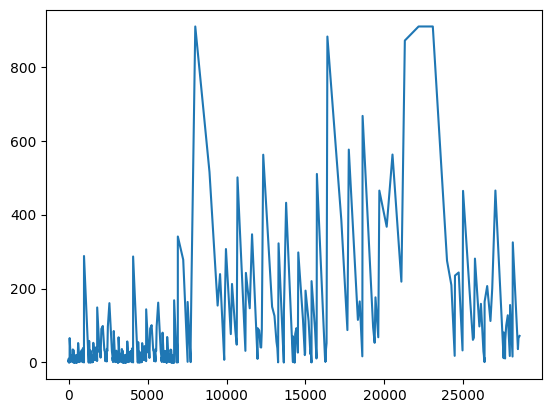

In [53]:
sns.lineplot(x=df["relative_start_time"].values, y=df["runtime"].values)

In [54]:
# logfns = glob.iglob(RESULTDIR + "/*/results/sar_logs*")
# logdfs = {}

# for fi, fn in enumerate(logfns):
#     #print(fn)
#     if ".csv" in fn or "sar_logs00" in fn:
#         continue
#     try:
#         curdf = pd.read_csv(fn, delimiter=";")
#     except Exception as e:
#         print(e)
#         continue
    
#     if 'kbmemfree' in curdf.keys():
#         logdfs["mem"] = curdf
#     elif "dropd/s" in curdf.keys():
#         logdfs["network1"] = curdf
#     elif "%sio-10" in curdf.keys():
#         #system load and pressure-stall statistics
#         logdfs["pressure_io"] = curdf
#     elif 'kbhugfree' in curdf.keys():
#         logdfs["hugepg"] = curdf
#     elif '%smem-10' in curdf.keys():
#         logdfs["pressure_mem"] = curdf
#     elif 'kbswpfree' in curdf.keys():
#         logdfs["swap"] = curdf
#     elif 'idgm6/s' in curdf.keys():
#         logdfs["network2"] = curdf
#     elif 'bdscd/s' in curdf.keys():
#         logdfs["io1"] = curdf
#     elif '%irq' in curdf.keys():
#         logdfs["cpu_utilization"] = curdf
#     elif 'atmptf/s' in curdf.keys():
#         logdfs["network3"] = curdf
#     elif 'idgm/s' in curdf.keys():
#         logdfs["network4"] = curdf
#     elif 'areq-sz' in curdf.keys():
#         logdfs["device_io"] = curdf
#     elif 'call/s' in curdf.keys():
#         logdfs["network_nfs"] = curdf
#     elif 'rxdrop/s' in curdf.keys():
#         logdfs["network5"] = curdf
#     elif 'rxcmp/s' in curdf.keys():
#         logdfs["network6"] = curdf
#     elif 'tcp6sck' in curdf.keys():
#         logdfs["network7"] = curdf
#     elif 'iseg/s' in curdf.keys():
#         logdfs["network8"] = curdf
#     elif 'pswpin/s' in curdf.keys():
#         logdfs["swap"] = curdf
#     elif 'intr/s' in curdf.keys():
#         logdfs["interrupts"] = curdf
#     elif '%scpu-10' in curdf.keys():
#         logdfs["pressure_cpu"] = curdf
#     elif 'MHz' in curdf.keys():
#         logdfs["power-cpu"] = curdf
#     elif 'degC' in curdf.keys():
#         logdfs["power-temp"] = curdf
#     elif '%ufsused' in curdf.keys():
#         logdfs["filesystem"] = curdf
#     elif 'cswch/s' in curdf.keys():
#         logdfs["context_switch"] = curdf
#     elif 'pgpgin/s' in curdf.keys():
#         logdfs["paging"] = curdf
#     elif 'fwddgm/s' in curdf.keys():
#         logdfs["network9"] = curdf
#     elif 'ihdrer6/s' in curdf.keys():
#         logdfs["network10"] = curdf
#     elif 'imsg/s' in curdf.keys():
#         logdfs["network11"] = curdf
#     elif 'ierr6/s' in curdf.keys():
#         logdfs["network12"] = curdf
#     elif 'scall/s' in curdf.keys():
#         logdfs["network13"] = curdf
#     elif 'runq-sz' in curdf.keys():
#         logdfs["pressure_load"] = curdf
#     elif 'dentunusd' in curdf.keys():
#         logdfs["inode"] = curdf
#     elif 'igmbq6/s' in curdf.keys():
#         logdfs["network14"] = curdf
#     elif 'tcpsck' in curdf.keys():
#         logdfs["network15"] = curdf
#     elif 'otmex/s' in curdf.keys():
#         logdfs["network16"] = curdf
#     elif 'ihdrerr/s' in curdf.keys():
#         logdfs["network17"] = curdf
#     elif 'irec6/s' in curdf.keys():
#         logdfs["network18"] = curdf
#     else:
#         assert False

In [55]:
all_logdfs = {}
for exp in EXP_NAMES:
    resultdir = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "new", exp)
    
    #logdfs = {}
    logfns = glob.iglob(resultdir + "/*/results/sar_logs*")
    #print(list(logfns))
    instance_dirs = os.listdir(resultdir)
    for iname in instance_dirs:
        if os.path.isdir(os.path.join(resultdir, iname)):
            all_logdfs[iname] = {}
        else:
            print(iname)
    
    ltdf = pd.read_csv(os.path.join(resultdir, LT_FN), header=None, 
           names=["instance", "lt"])
    ltdf = ltdf.merge(lt_types, on="lt")
    
    for fi, fn in enumerate(logfns):
        instance_name = os.path.basename(os.path.dirname(os.path.dirname(fn)))
        #print(instance_name)
        #all_logdfs[instance_name] = logdfs
        logdfs = all_logdfs[instance_name]

        if ".csv" in fn or "sar_logs00" in fn:
            continue
        try:
            curdf = pd.read_csv(fn, delimiter=";")
            #curdf["instance"] = instance_name
            #curdf = curdf.merge(ltdf, on="instance")
        except Exception as e:
            print("Exception@")
            print(e)
            continue

        if 'kbmemfree' in curdf.keys():
            logdfs["mem"] = curdf
        elif "dropd/s" in curdf.keys():
            logdfs["network1"] = curdf
        elif "%sio-10" in curdf.keys():
            #system load and pressure-stall statistics
            logdfs["pressure_io"] = curdf
        elif 'kbhugfree' in curdf.keys():
            logdfs["hugepg"] = curdf
        elif '%smem-10' in curdf.keys():
            logdfs["pressure_mem"] = curdf
        elif 'kbswpfree' in curdf.keys():
            logdfs["swap"] = curdf
        elif 'idgm6/s' in curdf.keys():
            logdfs["network2"] = curdf
        elif 'bdscd/s' in curdf.keys():
            logdfs["io1"] = curdf
        elif '%irq' in curdf.keys():
            logdfs["cpu_utilization"] = curdf
        elif 'atmptf/s' in curdf.keys():
            logdfs["network3"] = curdf
        elif 'idgm/s' in curdf.keys():
            logdfs["network4"] = curdf
        elif 'areq-sz' in curdf.keys():
            logdfs["device_io"] = curdf
        elif 'call/s' in curdf.keys():
            logdfs["network_nfs"] = curdf
        elif 'rxdrop/s' in curdf.keys():
            logdfs["network5"] = curdf
        elif 'rxcmp/s' in curdf.keys():
            logdfs["network6"] = curdf
        elif 'tcp6sck' in curdf.keys():
            logdfs["network7"] = curdf
        elif 'iseg/s' in curdf.keys():
            logdfs["network8"] = curdf
        elif 'pswpin/s' in curdf.keys():
            logdfs["swap"] = curdf
        elif 'intr/s' in curdf.keys():
            logdfs["interrupts"] = curdf
        elif '%scpu-10' in curdf.keys():
            logdfs["pressure_cpu"] = curdf
        elif 'MHz' in curdf.keys():
            logdfs["power-cpu"] = curdf
        elif 'degC' in curdf.keys():
            logdfs["power-temp"] = curdf
        elif '%ufsused' in curdf.keys():
            logdfs["filesystem"] = curdf
        elif 'cswch/s' in curdf.keys():
            logdfs["context_switch"] = curdf
        elif 'pgpgin/s' in curdf.keys():
            logdfs["paging"] = curdf
        elif 'fwddgm/s' in curdf.keys():
            logdfs["network9"] = curdf
        elif 'ihdrer6/s' in curdf.keys():
            logdfs["network10"] = curdf
        elif 'imsg/s' in curdf.keys():
            logdfs["network11"] = curdf
        elif 'ierr6/s' in curdf.keys():
            logdfs["network12"] = curdf
        elif 'scall/s' in curdf.keys():
            logdfs["network13"] = curdf
        elif 'runq-sz' in curdf.keys():
            logdfs["pressure_load"] = curdf
        elif 'dentunusd' in curdf.keys():
            logdfs["inode"] = curdf
        elif 'igmbq6/s' in curdf.keys():
            logdfs["network14"] = curdf
        elif 'tcpsck' in curdf.keys():
            logdfs["network15"] = curdf
        elif 'otmex/s' in curdf.keys():
            logdfs["network16"] = curdf
        elif 'ihdrerr/s' in curdf.keys():
            logdfs["network17"] = curdf
        elif 'irec6/s' in curdf.keys():
            logdfs["network18"] = curdf
        else:
            assert False

lt_instances.txt
lt_instances.txt
lt_instances.txt


In [56]:
print("Number of log files: ", len(logdfs))

todel = []
for instance,logdfs in all_logdfs.items():
    keys = list(logdfs.keys())
    tmp = df[df["instance"] == instance]
    if len(tmp) == 0:
        todel.append(instance)
        
for td in todel:
    del all_logdfs[td]

for instance,logdfs in all_logdfs.items():
    print(instance, len(logdfs))
    keys = list(logdfs.keys())
    tmp = df[df["instance"] == instance]

    min_qtime = min(tmp["start_time"].values)
    max_qtime = max(tmp["start_time"].values)

    for k in keys:
        if "network" in k:
            del logdfs[k]
            continue
        if "hugepg" in k:
            del logdfs[k]
            continue

        if len(logdfs[k]) == 0:
            continue

        mincur = min(logdfs[k]["timestamp"])
        logdfs[k]["relative_time"] = logdfs[k].apply(lambda x: x["timestamp"]-min_qtime , axis=1)
        logdfs[k] = logdfs[k][logdfs[k]["relative_time"] >= -10.0]
        
print("Number of log files w/o networking: ", len(logdfs))

Number of log files:  36
i-0b5cab95e080938d5 36
Number of log files w/o networking:  16


In [57]:
print(min(logdfs["paging"]["relative_time"]))

-3.616631507873535


In [58]:
all_logdfs.keys()

dict_keys(['i-0b5cab95e080938d5'])

In [59]:
logdfs["paging"]["relative_time"]

334        -3.616632
335         6.383368
336        16.383368
337        26.383368
338        36.383368
            ...     
6440    61056.383368
6441    61066.383368
6442    61076.383368
6443    61086.383368
6444    61096.383368
Name: relative_time, Length: 6111, dtype: float64

In [60]:
total = 0
for ldf in logdfs:
    print(ldf, logdfs[ldf].keys())
    total += len(logdfs[ldf].keys())

print("Num data points per timestamp: ", total - (36*3))

mem Index(['# hostname', 'interval', 'timestamp', 'kbmemfree', 'kbavail',
       'kbmemused', '%memused', 'kbbuffers', 'kbcached', 'kbcommit', '%commit',
       'kbactive', 'kbinact', 'kbdirty', 'kbanonpg', 'kbslab', 'kbkstack',
       'kbpgtbl', 'kbvmused', 'relative_time'],
      dtype='object')
pressure_io Index(['# hostname', 'interval', 'timestamp', '%sio-10', '%sio-60', '%sio-300',
       '%sio', '%fio-10', '%fio-60', '%fio-300', '%fio', 'relative_time'],
      dtype='object')
pressure_mem Index(['# hostname', 'interval', 'timestamp', '%smem-10', '%smem-60',
       '%smem-300', '%smem', '%fmem-10', '%fmem-60', '%fmem-300', '%fmem',
       'relative_time'],
      dtype='object')
swap Index(['# hostname', 'interval', 'timestamp', 'pswpin/s', 'pswpout/s',
       'relative_time'],
      dtype='object')
io1 Index(['# hostname', 'interval', 'timestamp', 'tps', 'rtps', 'wtps', 'dtps',
       'bread/s', 'bwrtn/s', 'bdscd/s', 'relative_time'],
      dtype='object')
cpu_utilization Index([

# Interrupts / s

In [61]:
logdfs["interrupts"].groupby("INTR")["intr/s"].describe()

,count,mean,std,min,25%,50%,75%,max
INTR,,,,,,,,
-1,6111.0,223.392852,453.338581,14.2,23.4,31.5,184.0,4834.6
0,6111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,6111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,6111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,6111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
435,6111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
436,6111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
437,6111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


# PageFaults / s

<AxesSubplot: xlabel='relative_time'>

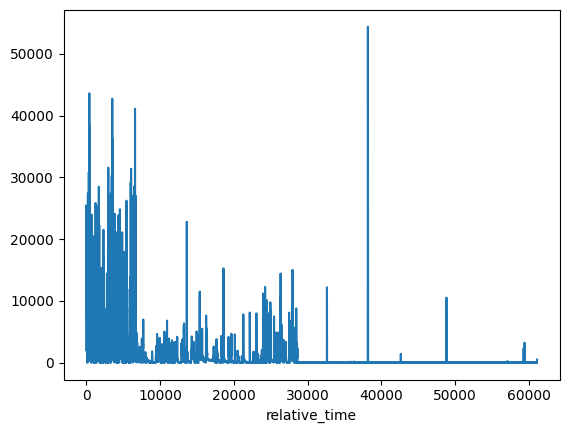

In [62]:
pgdf = logdfs["paging"]
sns.lineplot(x=pgdf["relative_time"], y=pgdf["fault/s"].values)

<AxesSubplot: >

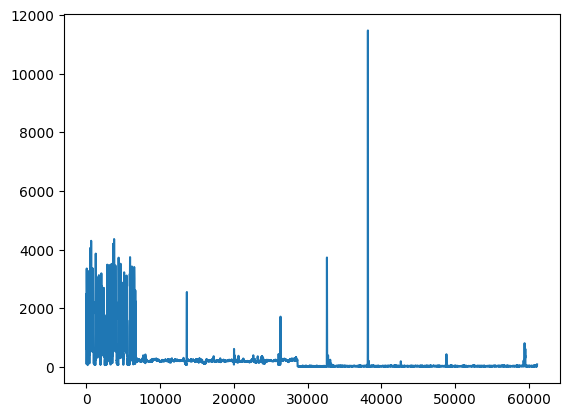

In [63]:
cdf = logdfs["context_switch"]
sns.lineplot(x=cdf["relative_time"].values, y=cdf["cswch/s"].values)

In [64]:
# powdf = logdfs["power-temp"]
# sns.lineplot(x=range(len(powdf)), y=powdf["degC"].values)

In [65]:
# powcpu = logdfs["power-cpu"]
# sns.lineplot(x=range(len(powcpu)), y=powcpu["MHz"].values)

In [66]:
pcpu = logdfs["pressure-cpu"]
sns.lineplot(x=pcpu["relative_time"].values, y=pcpu["%scpu"].values)

KeyError: 'pressure-cpu'

<AxesSubplot: xlabel='relative_time'>

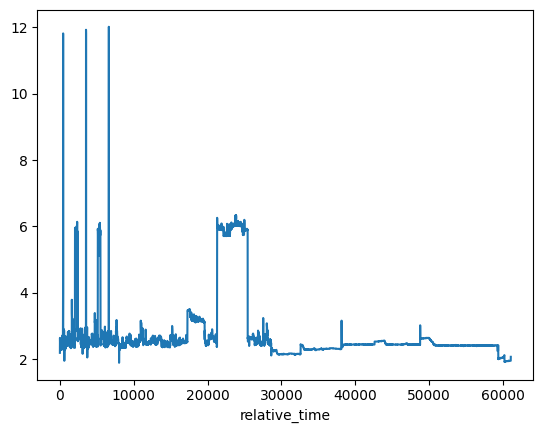

In [67]:
memdf = logdfs["mem"]
sns.lineplot(x=memdf["relative_time"], y=memdf["%memused"].values)

In [68]:
df.keys()

Index(['start_time', 'qname', 'runtime', 'exp_analyze', 'samples_type',
       'parallel_workers', 'no_index', 'drop_cache', 'col_store', 'result_dir',
       'query_dir', 'cost_model', 'materialize', 'explain', 'reps',
       'num_queries', 'timeout', 'rerun_timeouts', 'db_name', 'db_host',
       'user', 'pwd', 'port', 'instance', 'lt', 'lt_type',
       'relative_start_time', 'workload'],
      dtype='object')

<AxesSubplot: xlabel='relative_start_time', ylabel='runtime'>

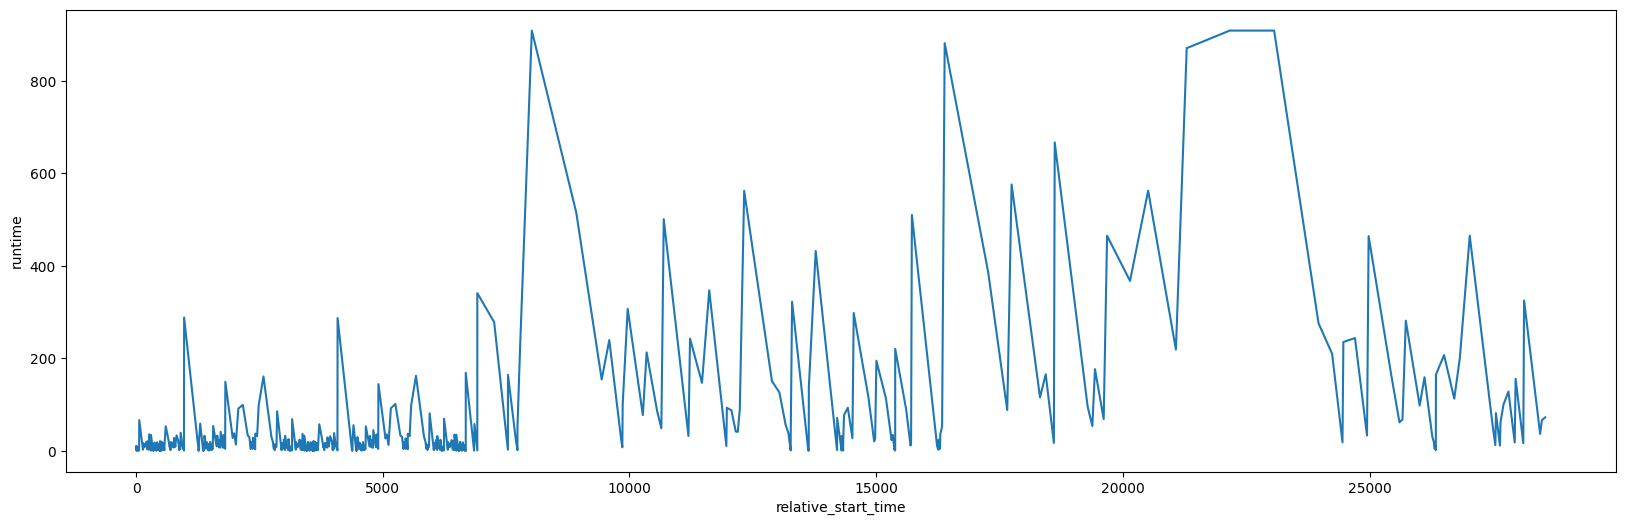

In [69]:
fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
sns.lineplot(data=df, x="relative_start_time", y = "runtime", ax=axs)

<AxesSubplot: xlabel='relative_start_time', ylabel='runtime'>

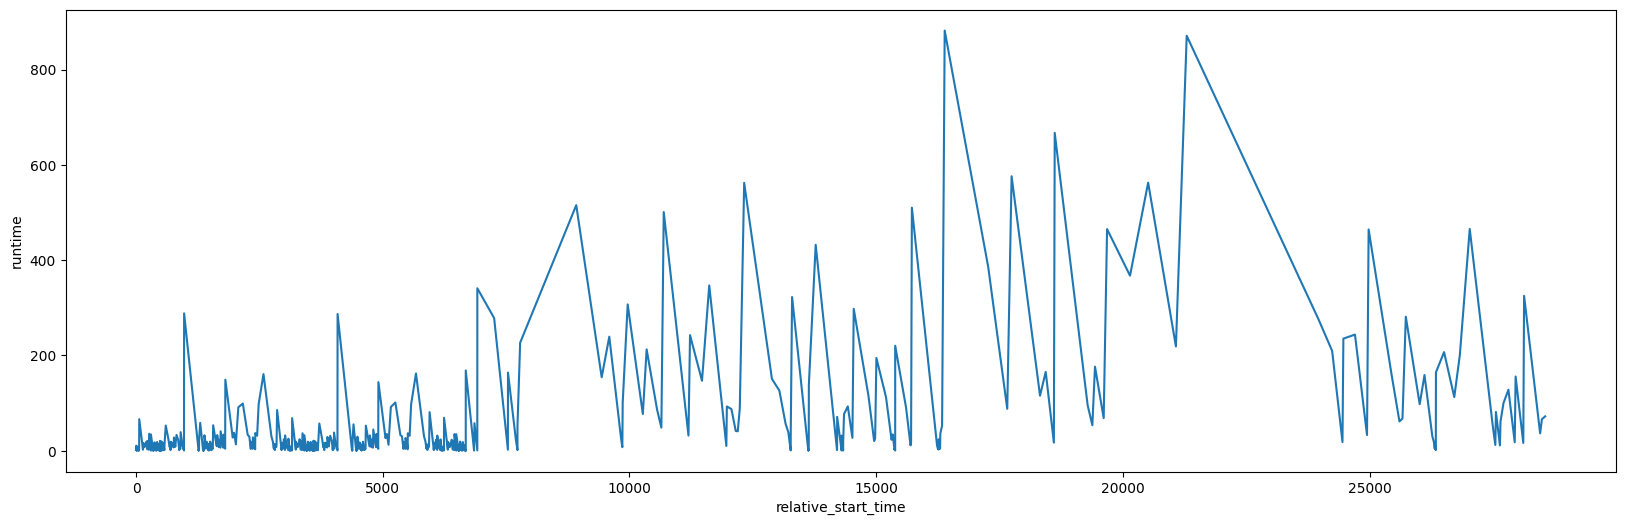

In [70]:
tmp = df[df["runtime"] <= 900.0]

fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
sns.lineplot(data=tmp, x="relative_start_time", y = "runtime", ax=axs)

In [71]:
# tmp = df[df["runtime"] <= 900.0]

# fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
# sns.histplot(data=tmp, x="relative_start_time", y = "runtime", stat="count", bins=1000, ax=axs)

<AxesSubplot: xlabel='relative_start_time', ylabel='runtime'>

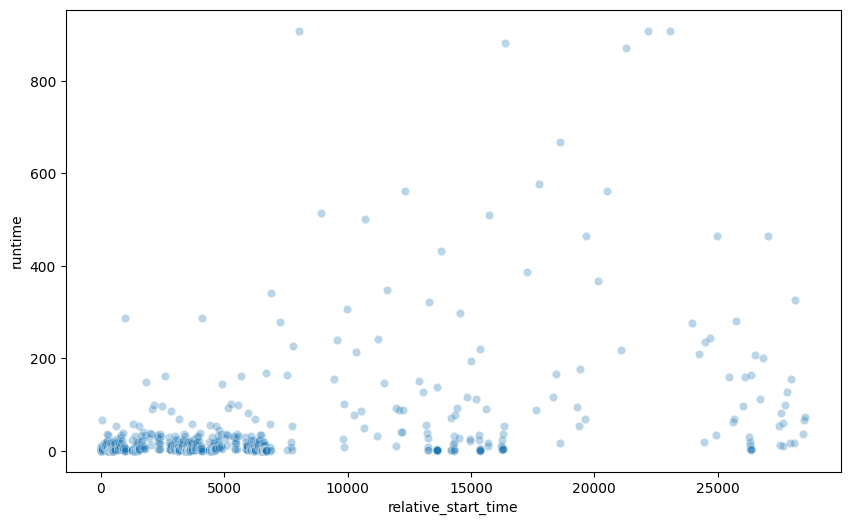

In [72]:
#tmp = df[df["runtime"] <= 900.0]

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
sns.scatterplot(data=df, x="relative_start_time", y = "runtime", ax=ax, alpha=0.3)


In [73]:
logdfs["device_io"].groupby(["DEV"])["areq-sz"].describe()

,count,mean,std,min,25%,50%,75%,max
DEV,,,,,,,,
loop0,6111.0,0.337378,4.222298,0.00,0.00,0.00,0.0,79.50
loop1,6111.0,0.000532,0.031495,0.00,0.00,0.00,0.0,2.25
loop2,6111.0,0.000913,0.043358,0.00,0.00,0.00,0.0,2.33
loop3,6111.0,0.000368,0.028782,0.00,0.00,0.00,0.0,2.25
loop4,6111.0,0.017611,0.985225,0.00,0.00,0.00,0.0,66.40
loop5,6111.0,0.012332,0.663353,0.00,0.00,0.00,0.0,39.00
loop6,2848.0,0.003869,0.148618,0.00,0.00,0.00,0.0,7.50
loop7,2847.0,0.003319,0.141361,0.00,0.00,0.00,0.0,7.20
nvme0n1,6111.0,11.105181,9.965309,4.28,6.87,8.59,12.0,245.00


In [74]:
print(min(logdfs["paging"]["timestamp"].values), max(logdfs["paging"]["timestamp"].values))
mins = min(logdfs["paging"]["timestamp"].values)
maxs = max(logdfs["paging"]["timestamp"].values)

1677183619 1677244719


In [75]:
print(min(df["start_time"].values), max(df["start_time"].values))
mins2 = min(df["start_time"].values)
maxs2 = max(df["start_time"].values)

1677183622.6166315 1677212181.8479743


In [76]:
"Seconds after which we started executing queries: ", mins2 - mins

('Seconds after which we started executing queries: ', 3.616631507873535)

In [77]:
"Seconds after which we finished executing queries: ", maxs - maxs2

('Seconds after which we finished executing queries: ', 32537.152025699615)

In [78]:
"Seconds for total sys logging: ", maxs - mins

('Seconds for total sys logging: ', 61100)

In [79]:
"Seconds for total query executions: ", maxs2 - mins2

('Seconds for total query executions: ', 28559.23134279251)

In [80]:
print(len(set(df["qname"])))

263


In [81]:
# import pandas as pd
# from bokeh.io import curdoc, output_notebook, output_file
# from bokeh.layouts import row, column
# from bokeh.models import Select, DataRange1d, ColumnDataSource
# from bokeh.plotting import figure

# output_notebook()
# # output_file('test.html')

# def get_dataset(src, key):
#     source = ColumnDataSource(data=src)
#     return source


# curdf = logdfs["mem"]
# cc = []
# for key in curdf.keys():
#     if key not in ["# hostname", "interval", "timestamp", "relative_time"]:
#         cc.append(key)

# sel = cc[0]
# # vselect = Select(value=ver, title='Statistic Name', options=sorted((cc)))
# # source = get_dataset(curdf, ver)

# plot = figure(plot_width=500, plot_height = 400, tools="", 
#               toolbar_location=None)
# plot.xaxis.axis_label = 'Unix Seconds'
# plot.yaxis.axis_label = 'Stats'
# plot.axis.axis_label_text_font_style = 'bold'

# plot.grid.grid_line_alpha = 0.3 
# plot.title.text = "System Statistics"

# lines = []
# for key in cc:
#     lines.append(plot.line(x='relative_time', y=key, source=source))
#     lines[-1].visible = False

# select = Select(title="Plot to show:", value=sel, options=cc)

# select.js_on_change("value", CustomJS(args=dict(lines=lines, options=cc), code="""
#     for (let i = 0, len = options.length; i < len; i++) {
#         if (this.value == options[i]) {
#             lines[i].visible = true
#         } else {
#             lines[i].visible = false
#         }
#     }
# """))

# layout = column(select, plot)
# show(layout)

# #show(column(controls, plot))

# Working code for bokeh

In [82]:
# import copy
# import pandas as pd
# from bokeh.io import curdoc, output_notebook, output_file
# from bokeh.layouts import row, column
# from bokeh.models import Select, DataRange1d, ColumnDataSource
# from bokeh.plotting import figure

# output_notebook()

# curdf = logdfs["mem"]
# cc = []
# for key in curdf.keys():
#     if key not in ["# hostname", "interval", "timestamp", "relative_time"]:
#         cc.append(key)

# sel = cc[0]

# src = copy.deepcopy(curdf)
# src["to_plot"] = src[sel]
# source = ColumnDataSource(data=src)

# plot = figure(plot_width=500, plot_height = 400, tools="", 
#               toolbar_location=None)
# plot.xaxis.axis_label = 'Unix Seconds'
# plot.yaxis.axis_label = 'Stats'
# plot.axis.axis_label_text_font_style = 'bold'

# plot.grid.grid_line_alpha = 0.3 
# plot.title.text = "System Statistics"

# plot.line(x='relative_time', y="to_plot", source=source)

# select = Select(title="Statistic", value=sel, options=cc)
# select.js_on_change("value", CustomJS(args=dict(source=source, select=select), code="""
#     source.data["to_plot"] = source.data[this.value];
#     source.change.emit()
# """))

# # fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
# # sns.scatterplot(data=df, x="relative_start_time", y = "runtime", ax=ax, alpha=0.3)

# layout = column(select, plot)
# show(layout)

# # output_file('test.html')

In [83]:
logdfs.keys()

dict_keys(['mem', 'pressure_io', 'pressure_mem', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure_cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure_load', 'inode'])

In [89]:
import copy
import pandas as pd
from bokeh.io import curdoc, output_notebook, output_file
from bokeh.layouts import row, column
from bokeh.models import Select, DataRange1d, ColumnDataSource, MultiChoice
from bokeh.plotting import figure

#output_notebook()
output_file("Query-System-Logs-{}.html".format(EXP_NAME))
KEY_ORDER = ["mem", "io1", "device_io", "cpu_utilization", 
            "pressure_mem", "pressure_io", "pressure_cpu", "pressure_load",
            "paging", "context_switch", 'interrupts', 'filesystem', 
             'inode',
            ]

def get_cur_plot(curdf, title):
    global common_xrange, common_x
    
    cc = []
    for key in curdf.keys():
        if key not in ["# hostname", "interval", "timestamp", "relative_time", "DEV", 
                      "FILESYSTEM",]:
            cc.append(key)

    sel = cc[0]
    src = curdf
    src = src.groupby("relative_time").mean().reset_index()
    src["to_plot"] = src[sel]
    
    source = ColumnDataSource(data=src)
    plot = figure(width=420, height = 400,
                  #x_range = common_xrange,
                 )
    
#     if common_xrange is None:
#         common_xrange = plot.x_range
#     else:
#         source.data["common_relative_time"] = common_x
    
    plot.xaxis.axis_label = 'Seconds'
    plot.yaxis.axis_label = 'Stat'
    plot.axis.axis_label_text_font_style = 'bold'
    plot.grid.grid_line_alpha = 0.3 
    plot.title.text = title
    plot.line(x='relative_time', y="to_plot", source=source)
    
#     if common_x is None:
#         plot.line(x='relative_time', y="to_plot", source=source)
#         common_x = source.data["relative_time"]
#         #common_x = source.data.relative_time
#     else:
#         plot.line(x="common_relative_time", y="to_plot", source=source)
        #plot.line(x=common_x, y=source.data["to_plot"])
        
    select = Select(title="Statistic", value=sel, options=cc)
    select.js_on_change("value", CustomJS(args=dict(source=source, select=select), code="""
        source.data["to_plot"] = source.data[this.value];
        source.change.emit()
    """))

    # fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
    # sns.scatterplot(data=df, x="relative_start_time", y = "runtime", ax=ax, alpha=0.3)

    layout = column(select, plot)
    return layout

common_xrange = None
common_x = None

hover = HoverTool(tooltips=[
            ('qname', '@qname'),
            #('std', '@std'),
            #('relative_start_time', '@relative_start_time'),
            ('runtime', '@runtime'),
        ])
        
        
#         runtime_plot = figure(title = "Query Runtimes", width=1600, height=400, tools=[hover])
#         runtime_plot.xaxis.axis_label = 'Seconds'


circles = {}
#runtime_plot = figure(title = "Query Runtimes", width=1600, height=400)

# List of default tools to include
default_tools = "pan,wheel_zoom,box_zoom,reset,save"

# Create the figure and add both the HoverTool and the default tools
runtime_plot = figure(title="Query Runtimes", width=1600, height=400, tools=f"{default_tools},hover")

# Adding the hover tool separately
runtime_plot.add_tools(hover)


runtime_plot.xaxis.axis_label = 'Start time'
runtime_plot.xaxis.axis_label = 'Exceution time (Seconds)'

allqnames = list(set(df["qname"]))
for qname in set(df["qname"]):
    tmp = df[df["qname"] == qname]
    #print(tmp)
    rtsource = ColumnDataSource(data=tmp)
    c1 = runtime_plot.circle('relative_start_time','runtime', source=rtsource,
                             fill_alpha=0.6, size=10)
    c1.visible = True
    circles[qname] = c1

### w/o separate circles for scatterplot
# rtsource = ColumnDataSource(data=df)
# runtime_plot.circle('relative_start_time','runtime', source=rtsource,fill_alpha=0.5, size=10)

### selection area
multi_choice = MultiChoice(title="Query Selector", value=["all"], options=allqnames + ["all"])
multi_choice.js_on_change("value", CustomJS(args=dict(circles=circles), code="""
    for (const [key, c1] of Object.entries(circles)) {
        if (this.value.includes("all")) {
            c1.visible = true
        } else if (this.value.includes(key)) {
            c1.visible = true
        } else {
            c1.visible = false
        }
    }
"""))

plots = []

for key in KEY_ORDER:
    if len(logdfs[key]) == 0:
        continue
    if key in ["swap", "temp"]:
        continue
    plots.append(get_cur_plot(logdfs[key], key))

#show(column(row(rtplots), row(plots[0:4]), row(plots[4:8]), row(plots[8:12]), row(plots[12:16])))
show(column(column(multi_choice, runtime_plot), row(plots[0:4]), row(plots[4:8]), row(plots[8:12]), row(plots[12:16])))

/var/folders/kq/_m01bm_55_b60jjn3jx066p80000gn/T/ipykernel_76676/2848724177.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = src.groupby("relative_time").mean().reset_index()
/var/folders/kq/_m01bm_55_b60jjn3jx066p80000gn/T/ipykernel_76676/2848724177.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = src.groupby("relative_time").mean().reset_index()
/var/folders/kq/_m01bm_55_b60jjn3jx066p80000gn/T/ipykernel_76676/2848724177.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify 

In [87]:
# import copy
# import pandas as pd
# from bokeh.io import curdoc, output_notebook, output_file
# from bokeh.layouts import row, column
# from bokeh.models import Select, DataRange1d, ColumnDataSource, MultiChoice
# from bokeh.plotting import figure

# def plot_all_instances(all_df):
    
#     for instance in all_logdfs:
        
#         curlogdfs = all_logdfs[instance]
#         df = all_df[all_df["instance"] == instance]
#         lttype = df["lt_type"].values[0]
        
#         reset_output()
#         output_file("Query-System-Logs-{}-{}.html".format(lttype, "imdb2"))

#         KEY_ORDER = ["mem", "io1", "device_io", "cpu_utilization", 
#                     "pressure_mem", "pressure_io", "pressure_cpu", "pressure_load",
#                     "paging", "context_switch", 'interrupts', 'filesystem', 
#                      'inode']

#         def get_cur_plot(curdf, title, common_xrange, common_x):
#             #global common_xrange, common_x

#             cc = []
#             for key in curdf.keys():
#                 if key not in ["# hostname", "interval", "timestamp", "relative_time", "DEV", 
#                               "FILESYSTEM",]:
#                     cc.append(key)

#             sel = cc[0]
#             src = curdf
#             src = src.groupby("relative_time").mean().reset_index()
#             src["to_plot"] = src[sel]

#             source = ColumnDataSource(data=src)

#             plot = figure(plot_width=420, plot_height = 400,
#                           x_range = common_xrange,
#                          )

#             if common_xrange is None:
#                 common_xrange = plot.x_range
#             else:
#                 source.data["common_relative_time"] = common_x

#             plot.xaxis.axis_label = 'Seconds'
#             plot.yaxis.axis_label = 'Stat'
#             plot.axis.axis_label_text_font_style = 'bold'
#             plot.grid.grid_line_alpha = 0.3 
#             plot.title.text = title


#             if common_x is None:
#                 plot.line(x='relative_time', y="to_plot", source=source)
#                 common_x = source.data["relative_time"]
#                 #common_x = source.data.relative_time
#             else:
#                 plot.line(x="common_relative_time", y="to_plot", source=source)
#                 #plot.line(x=common_x, y=source.data["to_plot"])

#             select = Select(title="Statistic", value=sel, options=cc)
#             select.js_on_change("value", CustomJS(args=dict(source=source, select=select), code="""
#                 source.data["to_plot"] = source.data[this.value];
#                 source.change.emit()
#             """))

#             layout = column(select, plot)
#             return layout, common_xrange, common_x

#         circles = {}
#         #df.groupby(["qname"])["runtime"].std().sort_values(by="std", ascending=False).head(60)
#         tmp_std = df.groupby(["qname"])["runtime"].std().reset_index().rename(columns={"runtime":"std"})
        
#         df = df.merge(tmp_std, on="qname")
        
#         hover = HoverTool(tooltips=[
#             ('qname', '@qname'),
#             ('std', '@std'),
#             ('relative_start_time', '@relative_start_time'),
#             ('runtime', '@runtime'),
#         ])
        
        
#         runtime_plot = figure(title = "Query Runtimes", width=1600, height=400, tools=[hover])
#         runtime_plot.xaxis.axis_label = 'Seconds'

#         allqnames = list(set(df["qname"]))
#         for qname in set(df["qname"]):
#             tmp = df[df["qname"] == qname]
#             rtsource = ColumnDataSource(data=tmp)
#             c1 = runtime_plot.circle('relative_start_time','runtime', source=rtsource,
#                                      fill_alpha=0.6, size=10)
#             c1.visible = True
#             circles[qname] = c1

#         ### w/o separate circles for scatterplot
#         # rtsource = ColumnDataSource(data=df)
#         # runtime_plot.circle('relative_start_time','runtime', source=rtsource,fill_alpha=0.5, size=10)

#         ### selection area
#         multi_choice = MultiChoice(title="Query Selector", value=["all"], options=allqnames + ["all"])
#         multi_choice.js_on_change("value", CustomJS(args=dict(circles=circles), code="""
#             for (const [key, c1] of Object.entries(circles)) {
#                 if (this.value.includes("all")) {
#                     c1.visible = true
#                 } else if (this.value.includes(key)) {
#                     c1.visible = true
#                 } else {
#                     c1.visible = false
#                 }
#             }
#         """))

#         plots = []
        
#         common_xrange = None
#         common_x = None
        
#         for key in KEY_ORDER:
#             if len(logdfs[key]) == 0:
#                 continue
#             if key in ["swap", "temp"]:
#                 continue
#             p1,common_xrange,common_x = get_cur_plot(curlogdfs[key], key, common_xrange, common_x)
#             plots.append(p1)

#         show(column(column(multi_choice, runtime_plot), row(plots[0:4]), row(plots[4:8]), row(plots[8:12]), 
#                     row(plots[12:16])))
        
# plot_all_instances(df)

/var/folders/kq/_m01bm_55_b60jjn3jx066p80000gn/T/ipykernel_76676/761575004.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = src.groupby("relative_time").mean().reset_index()


ValueError: failed to validate FigureOptions(...).x_range: expected an element of either Instance(Range), Either(Tuple(Float, Float), Tuple(Datetime, Datetime), Tuple(TimeDelta, TimeDelta)), Seq(String), Object(Series) or Object(GroupBy), got None

In [99]:
# import copy
# import pandas as pd
# from bokeh.io import curdoc, output_notebook, output_file
# from bokeh.layouts import row, column
# from bokeh.models import Select, DataRange1d, ColumnDataSource, MultiChoice
# from bokeh.plotting import figure

# def plot_all_instances(all_df):
    
#     for instance in all_logdfs:
        
#         curlogdfs = all_logdfs[instance]
#         #df = all_df[all_df["instance"] == instance]
#         df = all_df
#         #lttype = df["lt_type"].values[0]
#         lttype = "test"
        
#         reset_output()
#         output_file("Query-System-Logs-{}-{}.html".format(lttype, "imdb2"))

#         KEY_ORDER = ["mem", "io1", "device_io", "cpu_utilization", 
#                     "pressure_mem", "pressure_io", "pressure_cpu", "pressure_load",
#                     "paging", "context_switch", 'interrupts', 'filesystem', 
#                      'inode']

#         def get_cur_plot(curdf, title, common_xrange, common_x):
#             #global common_xrange, common_x

#             cc = []
#             for key in curdf.keys():
#                 if key not in ["# hostname", "interval", "timestamp", "relative_time", "DEV", 
#                               "FILESYSTEM",]:
#                     cc.append(key)

#             sel = cc[0]
#             src = curdf
#             src = src.groupby("relative_time").mean().reset_index()
#             src["to_plot"] = src[sel]

#             source = ColumnDataSource(data=src)

#             plot = figure(plot_width=420, plot_height = 400,
#                           x_range = common_xrange,
#                          )

#             if common_xrange is None:
#                 common_xrange = plot.x_range
#             else:
#                 source.data["common_relative_time"] = common_x

#             plot.xaxis.axis_label = 'Seconds'
#             plot.yaxis.axis_label = 'Stat'
#             plot.axis.axis_label_text_font_style = 'bold'
#             plot.grid.grid_line_alpha = 0.3 
#             plot.title.text = title


#             if common_x is None:
#                 plot.line(x='relative_time', y="to_plot", source=source)
#                 common_x = source.data["relative_time"]
#                 #common_x = source.data.relative_time
#             else:
#                 plot.line(x="common_relative_time", y="to_plot", source=source)
#                 #plot.line(x=common_x, y=source.data["to_plot"])

#             select = Select(title="Statistic", value=sel, options=cc)
#             select.js_on_change("value", CustomJS(args=dict(source=source, select=select), code="""
#                 source.data["to_plot"] = source.data[this.value];
#                 source.change.emit()
#             """))

#             layout = column(select, plot)
#             return layout, common_xrange, common_x

#         circles = {}
#         #df.groupby(["qname"])["runtime"].std().sort_values(by="std", ascending=False).head(60)
#         tmp_std = df.groupby(["qname"])["runtime"].std().reset_index().rename(columns={"runtime":"std"})
        
#         df = df.merge(tmp_std, on="qname")
        
#         hover = HoverTool(tooltips=[
#             ('qname', '@qname'),
#             ('std', '@std'),
#             ('relative_start_time', '@relative_start_time'),
#             ('runtime', '@runtime'),
#         ])
        
        
#         runtime_plot = figure(title = "Query Runtimes", plot_width=1600, plot_height=400, tools=[hover])
#         runtime_plot.xaxis.axis_label = 'Seconds'

#         allqnames = list(set(df["qname"]))
#         for qname in set(df["qname"]):
#             tmp = df[df["qname"] == qname]
#             rtsource = ColumnDataSource(data=tmp)
#             c1 = runtime_plot.circle('relative_start_time','runtime', source=rtsource,
#                                      fill_alpha=0.6, size=10)
#             c1.visible = True
#             circles[qname] = c1

#         ### w/o separate circles for scatterplot
#         # rtsource = ColumnDataSource(data=df)
#         # runtime_plot.circle('relative_start_time','runtime', source=rtsource,fill_alpha=0.5, size=10)

#         ### selection area
#         multi_choice = MultiChoice(title="Query Selector", value=["all"], options=allqnames + ["all"])
#         multi_choice.js_on_change("value", CustomJS(args=dict(circles=circles), code="""
#             for (const [key, c1] of Object.entries(circles)) {
#                 if (this.value.includes("all")) {
#                     c1.visible = true
#                 } else if (this.value.includes(key)) {
#                     c1.visible = true
#                 } else {
#                     c1.visible = false
#                 }
#             }
#         """))

#         plots = []
        
#         common_xrange = None
#         common_x = None
        
#         for key in KEY_ORDER:
#             if len(logdfs[key]) == 0:
#                 continue
#             if key in ["swap", "temp"]:
#                 continue
#             p1,common_xrange,common_x = get_cur_plot(curlogdfs[key], key, common_xrange, common_x)
#             plots.append(p1)

#         show(column(column(multi_choice, runtime_plot), row(plots[0:4]), row(plots[4:8]), row(plots[8:12]), 
#                     row(plots[12:16])))
        
# plot_all_instances(df)

In [453]:
# reset_output()
# output_notebook()

# reset_output()
# #output_notebook()

# FN_TMP = "./{EXP_NAME}/{QNAME}.html"
# TITLE_FMT = "{QUERY}.\n Start:{START}.\n Latency:{LAT}."
# COLS = 2

# make_dir(EXP_NAME)

# plot_data = {}

# for qi, qname in enumerate(list(set(df["qname"]))):
# #     if qi >= 2:
# #         break
    
#     fn = FN_TMP.format(EXP_NAME=EXP_NAME, QNAME=qname.replace(".sql", ""))
#     output_file(fn)
#     print(fn)
    
#     tmp = df[df["qname"] == qname]
#     tmp = tmp.sort_values(by="relative_start_time")
#     allplots = []
    
#     for ei, exp in enumerate(tmp["exp_analyze"].values):
#         try:
#             plan = eval(str(exp))
#             #print(plan)
#         except Exception as e:
#             print(e)
#             continue
        
#         lat = tmp["runtime"].values[ei]
#         stime = tmp["relative_start_time"].values[ei]
#         title = TITLE_FMT.format(QUERY=qname, START=stime, LAT = lat)

#         G = explain_to_nx(plan[0][0][0])
#         #print(len(G.nodes()))
#         aliases = extract_values(plan[0][0][0], "Alias")
#         #print(aliases)

#         p1 = bokeh_plot(G, showplot=False,  height=600, width=800, title=title)
#         p1.visible = True
#         allplots.append(p1)
        
#     allrows = []
#     num_rows = math.ceil(len(allplots) / COLS)
    
#     for i in range(num_rows):
#         allrows.append(row(allplots[i*COLS:i*COLS+COLS]))
    
#     save(column(allrows))
#     #show(column(row(allplots[0:3]), row(allplots[3:6]), row(allplots[6:9])))

Loading BokehJS ...

./t7xlarge-gp3-d/29c.html
./t7xlarge-gp3-d/25b.html
./t7xlarge-gp3-d/23a.html
./t7xlarge-gp3-d/2a714.html
./t7xlarge-gp3-d/6de21f7b6d08d84073c7496dbff73afba95d7c8d.html
./t7xlarge-gp3-d/30b.html
./t7xlarge-gp3-d/18a.html
./t7xlarge-gp3-d/11d.html
./t7xlarge-gp3-d/26b.html
./t7xlarge-gp3-d/24b.html
./t7xlarge-gp3-d/4a143.html
./t7xlarge-gp3-d/32b1cf5e7af7bd6231e2d73a1b56ecf21bbd9804.html
./t7xlarge-gp3-d/3a76.html
./t7xlarge-gp3-d/7a58.html
./t7xlarge-gp3-d/29a.html
./t7xlarge-gp3-d/7045b4dac1171674c69f224b25c3c73ad8d9ca03.html
./t7xlarge-gp3-d/19a.html
./t7xlarge-gp3-d/408f3f94c386672c03af6b01705edab10554bba2.html
./t7xlarge-gp3-d/1a972.html
./t7xlarge-gp3-d/3a315.html
./t7xlarge-gp3-d/1c.html
./t7xlarge-gp3-d/16d.html
./t7xlarge-gp3-d/2c99.html
./t7xlarge-gp3-d/32a.html
./t7xlarge-gp3-d/5b.html
./t7xlarge-gp3-d/8c.html
./t7xlarge-gp3-d/be5f621ca67267a999a86e6b9843728d6992d649.html
./t7xlarge-gp3-d/2a620.html
./t7xlarge-gp3-d/3ebf44254fc9a2ae77481169131fd0ab111a6c43.html
./t7xlarge-gp3

./t7xlarge-gp3-d/20a.html
./t7xlarge-gp3-d/8a400.html
./t7xlarge-gp3-d/2a245.html
./t7xlarge-gp3-d/8d.html
./t7xlarge-gp3-d/30c.html
./t7xlarge-gp3-d/6a508.html
./t7xlarge-gp3-d/15d.html
./t7xlarge-gp3-d/728f1ee9b87457c8b28490639330db5b8f5b1e1c.html
./t7xlarge-gp3-d/6a338.html
./t7xlarge-gp3-d/61959f7b7fcd01bb21afed4e91a731fb1e4f5a14.html
./t7xlarge-gp3-d/1a761.html
./t7xlarge-gp3-d/1a1974.html
./t7xlarge-gp3-d/e8c1806d3f6d16369058ed9c40cc6b4e2e56676e.html
./t7xlarge-gp3-d/2a348.html
./t7xlarge-gp3-d/cd252c4d15a8d118c1aae28bd1ec48c7f45584b2.html
./t7xlarge-gp3-d/14a.html
./t7xlarge-gp3-d/2c192.html
./t7xlarge-gp3-d/5a686.html
./t7xlarge-gp3-d/7a160.html


In [321]:
src.groupby("relative_time").mean().reset_index()

,relative_time,timestamp
0,0,1674686716
1,10,1674686726
2,20,1674686736
3,30,1674686746
4,40,1674686756
...,...,...
2280,22810,1674709526
2281,22820,1674709536
2282,22830,1674709546
2283,22840,1674709556


In [116]:
print(logdfs.keys())
print(len(logdfs.keys()))

dict_keys(['mem', 'pressure1', 'pressure2', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure-cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure-load', 'inode'])
16


In [644]:
logdfs["mem"].keys()

Index(['# hostname', 'interval', 'timestamp', 'kbmemfree', 'kbavail',
       'kbmemused', '%memused', 'kbbuffers', 'kbcached', 'kbcommit', '%commit',
       'kbactive', 'kbinact', 'kbdirty', 'kbanonpg', 'kbslab', 'kbkstack',
       'kbpgtbl', 'kbvmused'],
      dtype='object')

In [643]:
logdfs.keys()

dict_keys(['mem', 'pressure1', 'hugepg', 'pressure2', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure-cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure-load', 'inode'])